# An Introduction to Word Embeddings

In [ ]:
import os
import csv
import spacy
import spacy
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from time import time
from pylab import rcParams
%matplotlib inline
nlp = spacy.load("en_core_web_sm")
import gensim

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# UNCOMMENT AND RUN FOLLOWING LINES, THEN RESTART THE RUNTIME
# !pip uninstall gensim
# !pip install gensim

### Example code from Research papers o ArXiV

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
!cp "/content/drive/My Drive/data43/arxiv/arxiv.csv" "arxiv.csv"

In [ ]:
model = gensim.models.Word2Vec(documents, vector_size=100, min_count=100, window=5)

In [ ]:
%matplotlib inline

import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

from sklearn.manifold import TSNE

target_word = "bert"
selected_words = [w[0] for w in model.wv.most_similar(positive=[target_word], topn=200)] + [target_word]
embeddings = [model.wv[w] for w in selected_words] + model.wv["bert"]

mapped_embeddings = TSNE(n_components=2, metric='cosine', init='pca').fit_transform(embeddings)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:827: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


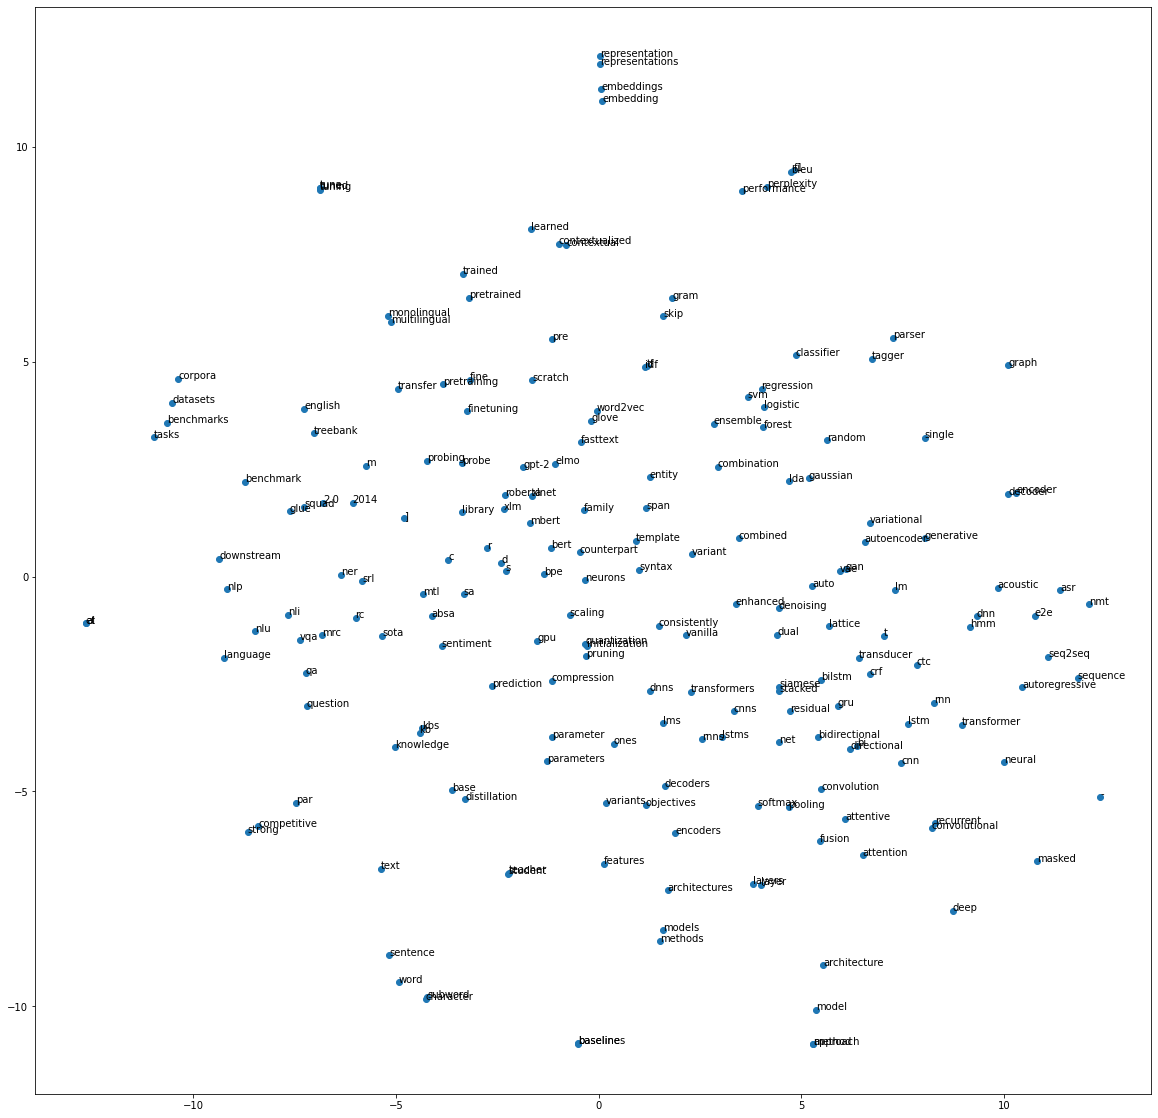

In [ ]:
plt.figure(figsize=(20,20))
x = mapped_embeddings[:,0]
y = mapped_embeddings[:,1]
plt.scatter(x, y)

for i, txt in enumerate(selected_words):
    plt.annotate(txt, (x[i], y[i]))

##### Parameter testing

In [ ]:
import spacy
from tqdm.notebook import tqdm

nlp = spacy.load("en_core_web_sm")

word2pos = {}
for word in tqdm(model.wv.key_to_index):
    word2pos[word] = nlp(word)[0].pos_

word2pos["translation"]

In [ ]:
import numpy as np

def evaluate(model, word2pos):
    same = 0
    for word in tqdm(model.wv.key_to_index):
        most_similar = model.wv.similar_by_word(word, topn=1)[0][0]
        if word2pos[most_similar] == word2pos[word]:
            same += 1
    return same/len(model.wv.key_to_index)
       
evaluate(model, word2pos)

In [ ]:
sizes = [100, 200, 300]
windows = [2,5,10]

df = pd.DataFrame(index=windows, columns=sizes)

for size in sizes:
    for window in windows:
        print("Size:", size, "Window:", window)
        # model = gensim.models.Word2Vec(documents, min_count=100, window=window, vector_size=size)
        # acc = evaluate(model, word2pos)
        # df[size][window] = acc
        
df

In [ ]:
df.plot()

### Working with quora dataset

##### Getting the data

In [ ]:
!unzip "drive/MyDrive/Quora-QnA/quora-question-pairs" -d "quora-question-pairs"
!unzip "quora-question-pairs/train.csv.zip"
!unzip "quora-question-pairs/test.csv.zip"

Archive:  drive/MyDrive/Quora-QnA/quora-question-pairs.zip
  inflating: quora-question-pairs/sample_submission.csv.zip  
  inflating: quora-question-pairs/test.csv  
  inflating: quora-question-pairs/test.csv.zip  
  inflating: quora-question-pairs/train.csv.zip  
Archive:  quora-question-pairs/train.csv.zip
  inflating: train.csv               
Archive:  quora-question-pairs/test.csv.zip
  inflating: test.csv                


In [ ]:
import pandas as pd
df = pd.read_csv("train.csv")

In [ ]:
# Reduce the data size when writing code to reduce waiting time
# df = df[:1000]
df

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0
...,...,...,...,...,...,...
404285,404285,433578,379845,How many keywords are there in the Racket prog...,How many keywords are there in PERL Programmin...,0
404286,404286,18840,155606,Do you believe there is life after death?,Is it true that there is life after death?,1
404287,404287,537928,537929,What is one coin?,What's this coin?,0
404288,404288,537930,537931,What is the approx annual cost of living while...,I am having little hairfall problem but I want...,0


##### General preprocessing

In [ ]:
nan_rows = df[df.isnull().any(1)]
df = df.fillna('')
nan_rows = df[df.isnull().any(1)]

In [ ]:
counter = 0
ls =[]
to_remove_indices = []
for i in df['question1']:
  i = str(i).split()
  if len(i) <= 2:
    ls.append(counter)
  counter+=1

for i in range(len(ls)-1,-1,-1):
  df = df.drop(ls[i])

In [ ]:
print(df.iloc[0]['question1'])
print(df.iloc[0]['question2'])

What is the step by step guide to invest in share market in india?
What is the step by step guide to invest in share market?


In [ ]:
# class Corpus(object):

#     def __init__(self, filename):
#         self.filename = filename
#         self.nlp = spacy.blank("en")
        
#     def __iter__(self):
#       with open("train.csv", "r") as i:
#           reader = csv.reader(i, delimiter=",")
#           count = 0
#           for _,_,_,_,question2,_ in reader:
#             # if count > 8:
#             #   break
#             tokens = [t.text.lower() for t in spacy.blank("en")(question2)]
#             count +=1
#             yield tokens

                            
                    
# documents = Corpus("train.csv")
# model = gensim.models.Word2Vec(documents, vector_size=100, min_count=1, window=5)

##### Training the model

In [ ]:
for i in range(len(df)):
  if type(df.iloc[i]['question1']) != type("") or type(df.iloc[i]['question2']) != type(""):
    print(df.iloc[i])
  if i%20000 == 0:
    print(i)


0
20000
40000
60000
80000
100000
120000
140000
160000
180000
200000
220000
240000
260000
280000
300000
320000
340000
360000
380000
400000


In [ ]:
ls = list(df['question1'])
ls.extend(list(df['question2']))
tokenized = []
counter = 0
t = time()
for q in ls:
  doc = nlp(q)
  new_ls = []
  # for token in temp:
  new_ls = [token.lemma_ for token in doc if not token.is_stop]
  if len(new_ls)> 1:
    tokenized.append(new_ls)
  if counter%20000==0:
    print(counter)
    print('Counter: " ,counter, "Time to for last 20000: {} mins'.format(round((time() - t) / 60, 2)))
    t = time()
  counter+=1



In [ ]:
tokenized[:2]

[['step', 'step', 'guide', 'invest', 'share', 'market', 'india', '?'],
 ['story', 'Kohinoor', '(', 'Koh', '-', '-', 'Noor', ')', 'Diamond', '?']]

In [ ]:
d= iter(tokenized)
model = gensim.models.Word2Vec(sentences=d, window=5, min_count=1, workers=4)

##### Exploring the model

In [ ]:
print(model.wv.most_similar('computer', topn=5))

[('kindergartner', 0.407546728849411), ('Judith', 0.3952207565307617), ('euglena', 0.3838363289833069), ('m.math', 0.3739769160747528), ('heavyset', 0.37178367376327515)]


In [ ]:
print(model.wv.most_similar('JEE', topn=5))

[('interjection', 0.45671403408050537), ('Duty', 0.40181127190589905), ('chaiye', 0.39327022433280945), ('/√', 0.39108893275260925), ('Rubio', 0.3829805850982666)]


In [ ]:
print(model.wv.most_similar('earn', topn=5))

[('-c', 0.4579944908618927), ('Sant', 0.43669039011001587), ('Banaras', 0.4287931025028229), ('Greg', 0.40911468863487244), ('entomologist', 0.40141886472702026)]


In [ ]:
print(model.wv.most_similar('relationship', topn=5))

[('10.9.5', 0.4325087070465088), ('medallion', 0.39536845684051514), ('sustainable', 0.386275976896286), ('MILP', 0.3848889172077179), ('Tashi', 0.3813139498233795)]


##### Displaying the embedding on a 2-d axis

In [ ]:
def show_closest_to(target_word):
  selected_words = [w[0] for w in model.wv.most_similar(positive=[target_word], topn=100)] + [target_word]
  embeddings = [model.wv[w] for w in selected_words] + model.wv["computer"]
  mapped_embeddings = TSNE(n_components=2, metric='cosine', init='pca').fit_transform(embeddings)
  rcParams['figure.figsize'] = 5, 10
  plt.figure(figsize=(15,15))
  x = mapped_embeddings[:,0]
  y = mapped_embeddings[:,1]
  plt.scatter(x, y)
  for i, txt in enumerate(selected_words):
      plt.annotate(txt, (x[i], y[i]))

Below is the representation of the 100 words closest to the word "computer", "maths", "death" and "earn"

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:827: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


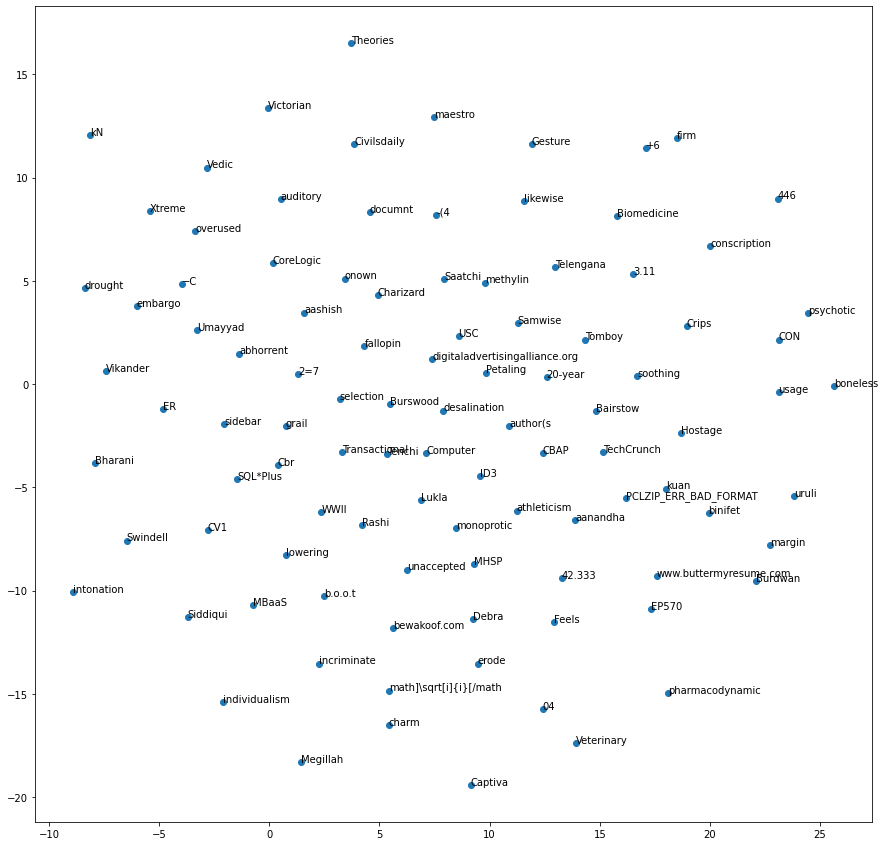

In [ ]:
show_closest_to("Computer")

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:827: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 40565 missing from cu

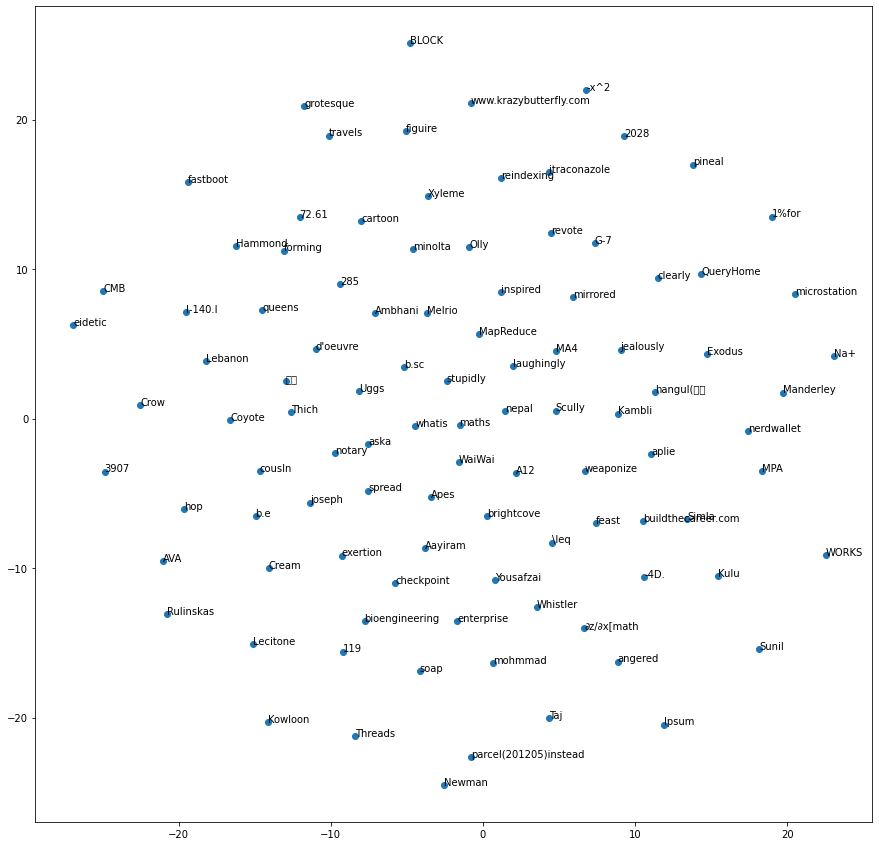

In [ ]:
show_closest_to("maths")

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:827: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


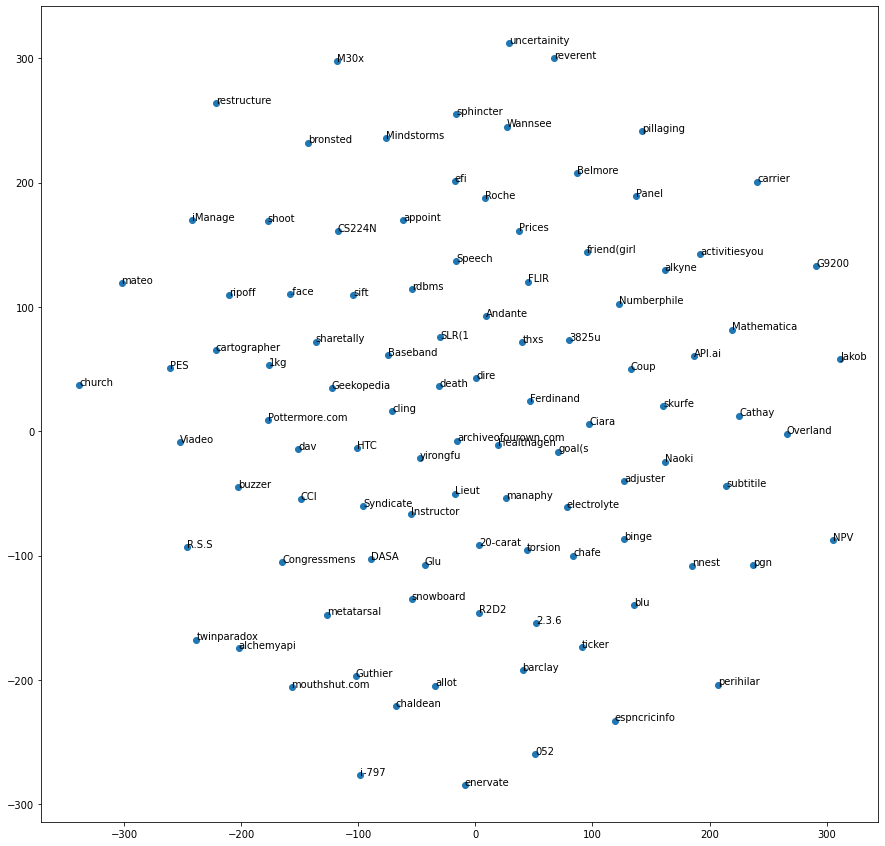

In [ ]:
show_closest_to("death")

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:827: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


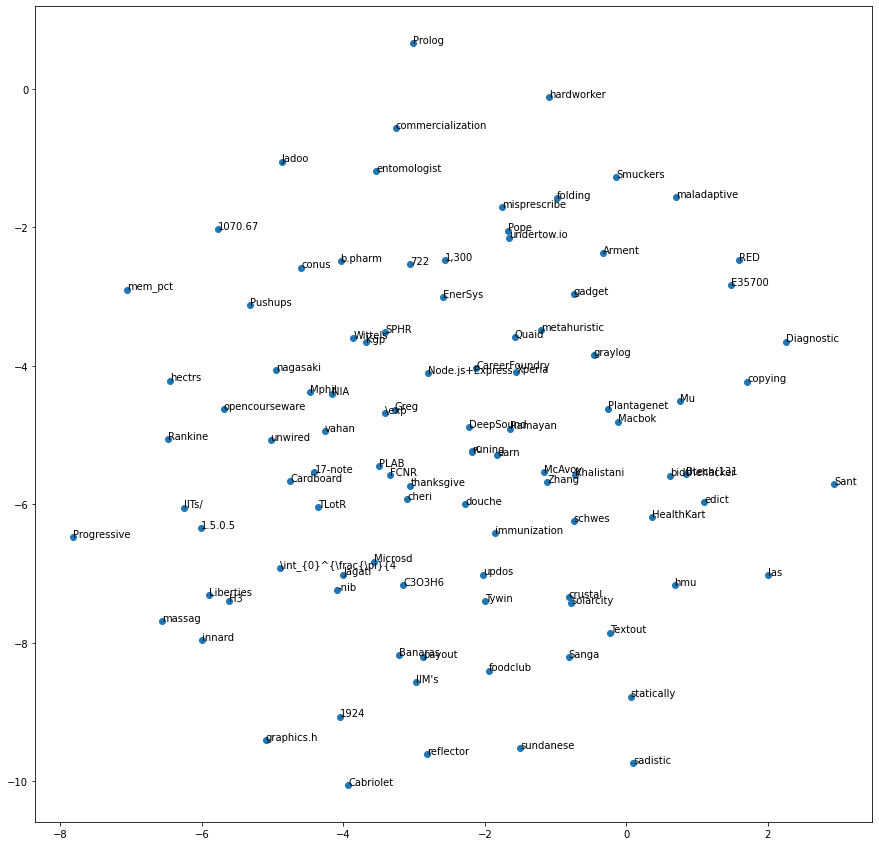

In [ ]:
show_closest_to("earn")

##### Save the model

In [ ]:
model.save("word2vec.model")

In [ ]:
print("hie")

hie
